In [1]:
# Step 1: Reinstallazione delle librerie necessarie
!pip uninstall transformers -y
!pip uninstall accelerate -y
!pip install transformers[torch]
!pip install accelerate -U
!pip install aiohttp
!pip install datasets
!pip install torch

# Step 2: Importazione delle librerie
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
import json
import re
from tqdm import tqdm

Found existing installation: transformers 4.41.2
Uninstalling transformers-4.41.2:
  Successfully uninstalled transformers-4.41.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 31.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# GET THE DATASET DIVERSEVUL
f = open('/content/drive/MyDrive/DiverseVul_AST_primo.json')
data = json.load(f)
dv = pd.DataFrame(data)
dv.info()
dv.groupby('target').describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21546 entries, 0 to 21545
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   func    21546 non-null  object
 1   target  21546 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 336.8+ KB


func                                                               
        count unique                                                top freq
target                                                                      
0       10630  10629  `-FunctionDecl 0x12f928680  col:7 implicit use...    2
1       10916  10916  `-FunctionDecl 0x15b940c98  line:1:23 dcn10_cr...    1

In [5]:
import pandas as pd
import re

df=dv.copy()

# Funzione per sostituire \n con spazio
def replace_newlines(text):
    return text.replace('\n', ' ')

# Funzione per contare i token
def count_tokens(text):
    tokens = re.findall(r'\w+', text)
    return len(tokens)

# Sostituire \n con spazio
df['func'] = df['func'].apply(replace_newlines)

# Filtrare le righe con un numero di token minore di 5 o maggiore di 256
#df = df[df['func'].apply(count_tokens).between(5, 256)]

# Contare le entry dopo il pre-processing
numero_di_entry = dv.shape[0]
numero_di_entry_dopo = df.shape[0]

# Mostrare il numero di entry
print(f"Numero di entry prima il pre-processing: {numero_di_entry}")
print(f"Numero di entry dopo il pre-processing: {numero_di_entry_dopo}")

Numero di entry prima il pre-processing: 21546
Numero di entry dopo il pre-processing: 21546


In [6]:
prima_entry_func = dv['func'].iloc[0]
print(f"Prima: {prima_entry_func}")

dopo_entry_func = df['func'].iloc[0]
print(f"Dopo: {dopo_entry_func}")

Prima: `-FunctionDecl 0x13e942650  col:41 implicit used floor 'double (double)' extern
  |-ParmVarDecl 0x13e942750 <<invalid sloc>> <invalid sloc> 'double'
  |-BuiltinAttr 0x13e9426f8 <<invalid sloc>> Implicit 1079
  |-NoThrowAttr 0x13e9427c0 <col:41> Implicit
  `-ConstAttr 0x13e942c00 <col:41> Implicit

Dopo: `-FunctionDecl 0x13e942650  col:41 implicit used floor 'double (double)' extern   |-ParmVarDecl 0x13e942750 <<invalid sloc>> <invalid sloc> 'double'   |-BuiltinAttr 0x13e9426f8 <<invalid sloc>> Implicit 1079   |-NoThrowAttr 0x13e9427c0 <col:41> Implicit   `-ConstAttr 0x13e942c00 <col:41> Implicit 


In [7]:
union = df.copy()
vv = df[df['target'] == 1]
nv = df[df['target'] == 0]

# Check the lengths of the subsets
len_vv = len(vv)
len_nv = len(nv)

# Sample from the subset with fewer rows
if len_nv >= len_vv:
    nv_sample = nv.sample(n=len_vv, replace=False)
else:
    nv_sample = nv.sample(n=len_nv, replace=False)
    vv = vv.sample(n=len_nv, replace=False)

# Concatenate the sampled dataframes
union = pd.concat([vv, nv_sample])

# Shuffle the resulting dataframe
union = union.sample(frac=1).reset_index(drop=True)


In [8]:
df=union.copy()
# SPLIT IN 3 SET AND STRATITY
df_v = df[df['target']==1]
split1 = int(len(df_v)*0.9)
split2 = int(len(df_v)*0.95)
df_v_train= df_v[:split1]
df_v_valid= df_v[split1:split2]
df_v_test = df_v[split2:]

df_n = df[df['target']==0]
split1 = int(len(df_n)*0.9)
split2 = int(len(df_n)*0.95)
df_n_train= df_n[:split1]
df_n_valid= df_n[split1:split2]
df_n_test = df_n[split2:]

# MERGE AND SHUFFLE ITEMS
df_train = pd.concat([df_v_train,df_n_train])
df_train = df_train.sample(frac = 1)
df_valid = pd.concat([df_v_valid,df_n_valid])
df_valid = df_valid.sample(frac = 1)
df_test  = pd.concat([df_v_test, df_n_test])
df_test  = df_test.sample(frac = 1)

print("TOTAL:",len(df))

print("TRAIN VUL    :",len(df_train[df_train['target']==0]))
print("TRAIN NON VUL:",len(df_train[df_train['target']==1]))
print("VALID VUL    :",len(df_valid[df_valid['target']==0]))
print("VALID NON VUL:",len(df_valid[df_valid['target']==1]))
print("TEST VUL     :",len(df_test[df_test['target']==0]))
print("TEST NON VUL :",len(df_test[df_test['target']==1]))

TOTAL: 21260
TRAIN VUL    : 9567
TRAIN NON VUL: 9567
VALID VUL    : 531
VALID NON VUL: 531
TEST VUL     : 532
TEST NON VUL : 532


In [9]:
train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_valid)
test_dataset = Dataset.from_pandas(df_test)

In [12]:
# Step 4: Tokenizzazione
tokenizer = AutoTokenizer.from_pretrained("saikatc/NatGen")

def preprocess_function(examples):
    # Tokenizza i dati e includi le etichette (labels)
    inputs = tokenizer(examples['func'], truncation=True, padding='max_length', max_length=256)
    inputs['labels'] = examples['target']
    return inputs

train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

# Step 5: Caricamento del modello
model = AutoModelForSequenceClassification.from_pretrained("saikatc/NatGen", num_labels=2)

# Step 6: Definizione degli argomenti di addestramento
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/output/',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    save_total_limit=1,           # Salva solo il modello finale
    save_steps=10000,             # Imposta un valore molto alto per save_steps
)

# Step 7: Definizione del Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # Utilizza il set di validazione
)

Map:   0%|          | 0/19134 [00:00<?, ? examples/s]

Map:   0%|          | 0/1062 [00:00<?, ? examples/s]

Map:   0%|          | 0/1064 [00:00<?, ? examples/s]

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at saikatc/NatGen and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
# Step 8: Addestramento del modello
trainer.train()


Epoch,Training Loss,Validation Loss
1,0.692100,0.656935


TrainOutput(global_step=2392, training_loss=0.7119203778014933, metrics={'train_runtime': 2166.433, 'train_samples_per_second': 8.832, 'train_steps_per_second': 1.104, 'total_flos': 5843302735472640.0, 'train_loss': 0.7119203778014933, 'epoch': 1.0})

In [14]:

# Step 9: Valutazione del modello
results = trainer.evaluate(eval_dataset=test_dataset)  # Utilizza il set di test per la valutazione finale
print(results)

{'eval_loss': 0.6731816530227661, 'eval_runtime': 38.2607, 'eval_samples_per_second': 27.809, 'eval_steps_per_second': 3.476, 'epoch': 1.0}


Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.48      0.53       532
           1       0.56      0.67      0.61       532

    accuracy                           0.58      1064
   macro avg       0.58      0.58      0.57      1064
weighted avg       0.58      0.58      0.57      1064



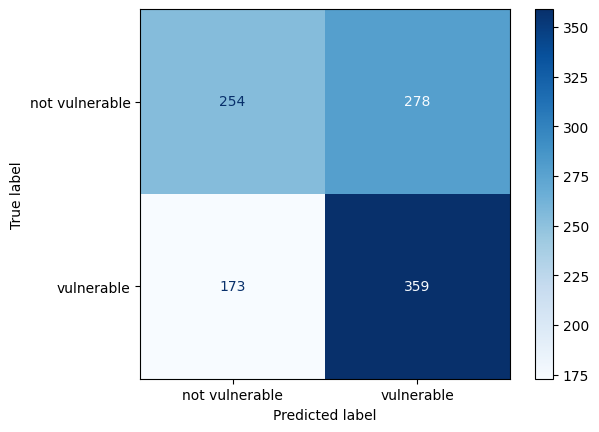

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Step 10: Valutazione del modello su set di test
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions[0], axis=1)  # Accessing the logits

true_labels = test_dataset['labels']

# Step 11: Stampa del classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

target_names = ['not vulnerable', 'vulnerable']

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualizza la matrice di confusione
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()



In [16]:
import numpy as np

# Salvataggio dell'array NumPy
np.save('/content/drive/MyDrive/natGen_AST_PRIMO.npy', predicted_labels)

In [17]:
import numpy as np

# Carica il file numpy con allow_pickle=True
predicted_labels2 = np.load('/content/drive/MyDrive/natGen_AST_PRIMO.npy', allow_pickle=True)

predicted_labels2

array([1, 1, 1, ..., 1, 1, 0])

In [18]:
import pandas as pd

# Salva il DataFrame in formato JSON
df_test.to_json('/content/drive/MyDrive/df_test_AST_PRIMO.json')
df_train.to_json('/content/drive/MyDrive/df_train_AST_PRIMO.json')
df_valid.to_json('/content/drive/MyDrive/df_valid_AST_PRIMO.json')